In [1]:
# from sklearn.cross_validation import train_test_split # scikit-learn version <= 0.17
from sklearn.model_selection import train_test_split # for scikit-learn >= 0.18 use:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
from sklearn import svm
from skimage.feature import hog

from scipy.ndimage.measurements import label

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time

%matplotlib inline

# Helper Functions


#### General Functions

In [2]:
def get_data():
    """Returns a list of directory paths to car and not car images"""
    images = glob.glob('./datasets/*.png')
    cars = []
    notcars = []
    for image in images:
        if 'no_car' in image:
            notcars.append(image)
        else:
            cars.append(image)
    return cars, notcars

def bin_spatial(img, size=(32, 32)):
    """Computes binned color features"""
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

 
def color_hist(img, nbins=32, bins_range=(0, 256)):
    """
    Computes color histogram features.
    Note: NEED TO CHANGE bins_range if reading .png files with mpimg!
    """
    # Computes the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenates the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Returns the individual histograms, bin_centers and feature vector
    return hist_features

def cvt_colorspace(image, color_space):
    """Converts image colorspace"""
    # applies color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            return cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            return cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            return cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            return cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            return cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    else:
        return np.copy(image)


def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    """Draw bounding boxes"""
    # Makes a copy of the image
    imcopy = np.copy(img)
    # Iterates through the bounding boxes
    for bbox in bboxes:
        # Draws a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Returns the image copy with boxes drawn
    return imcopy



#### Feature Extractors

In [3]:
def extract_features(imgs,
                     color_space='RGB',
                     spatial_size=(32, 32),
                     hist_bins=32,
                     orient=9,
                     pix_per_cell=8,
                     cell_per_block=2,
                     hog_channel=0,
                     spatial_feat=True,
                     hist_feat=True,
                     hog_feat=True):
    """Extract features from a list of images"""
    # Creates a list to append feature vectors to
    features = []
    # Iterates through the list of images
    for file in imgs:
        file_features = []
        # Reads in each one by one
        image = mpimg.imread(file)
        # Converts colorspace
        feature_image = cvt_colorspace(image, color_space)

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Applies color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Appends the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Returns list of feature vectors
    return features


def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    """Returns HOG features and visualization"""
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img,
                                  orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  block_norm= 'L2-Hys',
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis,
                                  feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img,
                       orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       block_norm= 'L2-Hys',
                       transform_sqrt=True, 
                       visualise=vis,
                       feature_vector=feature_vec)
        return features


def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    """
    Extract features from a single image window.
    Similar to extract-features but extracts for a single image.
    """
    # Defines an empty list to receive features
    img_features = []
    
    # Applies color conversion if other than 'RGB'
    feature_image = cvt_colorspace(img, color_space)
    
    # Computes spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        # Appends features to list
        img_features.append(spatial_features)
        
    # Computes histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        # Appends features to list
        img_features.append(hist_features)
    # Computes HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Appends features to list
        img_features.append(hog_features)

    # Returns concatenated array of features
    return np.concatenate(img_features)

#### Sliding Windows

In [4]:
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    """
    Creates a list of windows which to be searched for HOG features.
    
    Params: 
    - start and stop positions in both x and y
    - window size (x and y dimensions)
    - overlap fraction (for both x and y)
    
    Return: list of windows
    """
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
        
    # Computes the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    
    # Computes the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    
    # Computes the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    
    # Initializes a list to append window positions to
    window_list = []
    
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Appends window position to list
            window_list.append(((startx, starty), (endx, endy)))
            
    # Returns the list of windows
    return window_list


def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):
    """Passes an image and a list of windows to be searched"""

    # Create an empty list to receive positive detection windows
    on_windows = []
    
    # Iterates over all windows in the list
    for window in windows:
        # Extracts the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64)) 
        
        # Extracts features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        
        # Scales extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        
        # Predicts using your classifier
        prediction = clf.predict(test_features)
        
        # If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
            
    # Returns windows for positive detections
    return on_windows

In [5]:
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, color_space, window_size):
    """Extract features using hog sub-sampling and make predictions"""
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Defines blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Computes individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extracts the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Gets color features
#             spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scales features and make a prediction
#             test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))
            test_features = X_scaler.transform(np.hstack((hist_features, hog_features)).reshape(1, -1))
            
            # makes prediction
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                
    return draw_img

def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

#### Heatmap Functions

In [6]:
def add_heat(heatmap, bbox_list):
    """Apply heatmap functionality to an image"""
    # Iterates through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Returns updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    """Applies threshold to the heatmap"""
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Returns thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    """Draws final bounding boxes based on heatmap"""
    # Iterates through all detected cars
    for car_number in range(1, labels[1]+1):
        # Finds pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        
        # Identifies x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        
        # Defines a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        
        # Draws the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Returns the image
    return img

### Get car and not car data

In [7]:
# gets cars and not cars image data
cars, notcars = get_data()

#### Visualize cars and notcars

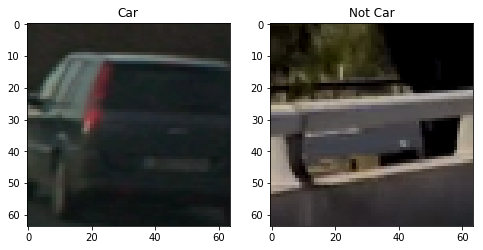

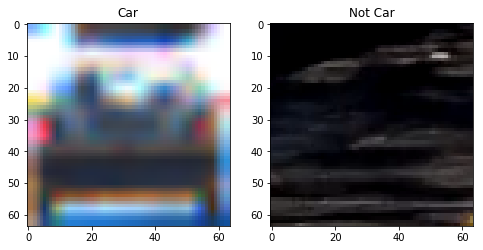

In [8]:
for i in range(2):
    car = mpimg.imread(cars[i])
    notcar = mpimg.imread(notcars[i])
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 8))
    ax1.set_title('Car')
    ax1.imshow(car)
    ax2.set_title('Not Car')
    ax2.imshow(notcar)

### Visualize Data in Different Color Spaces

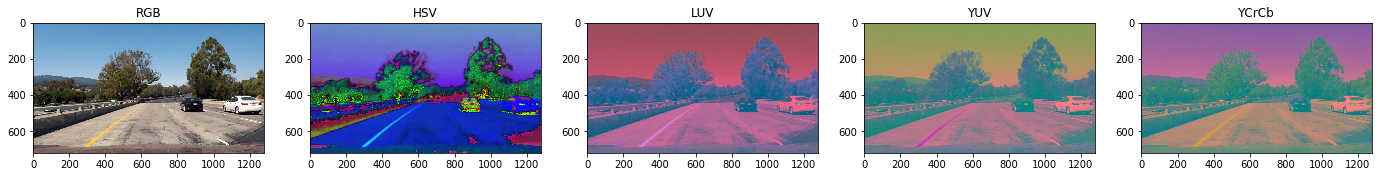

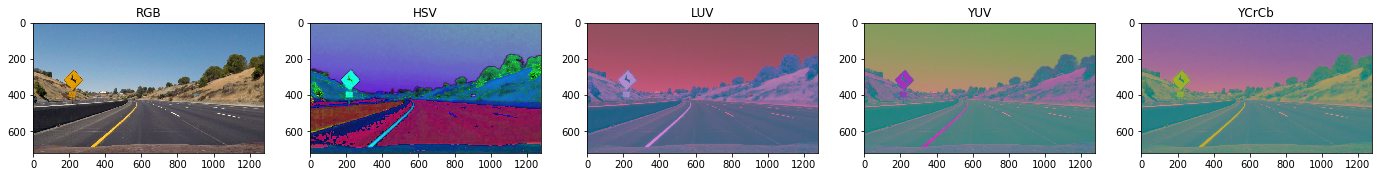

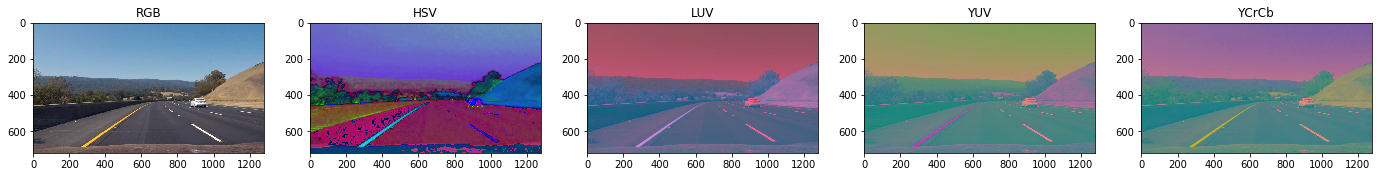

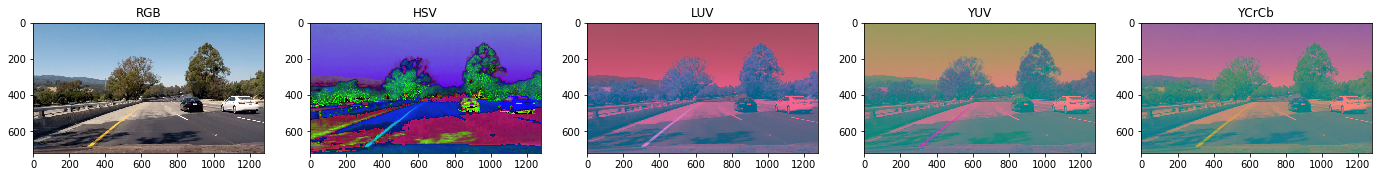

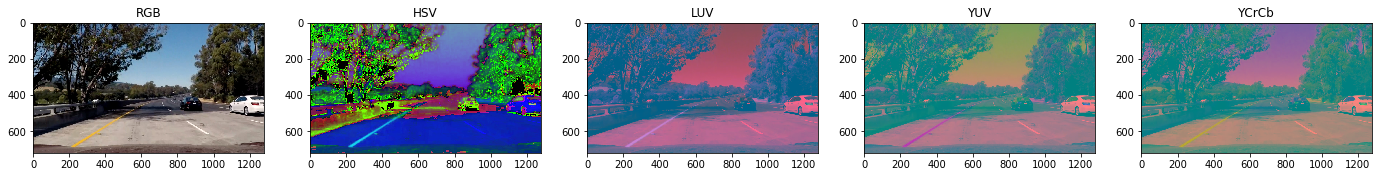

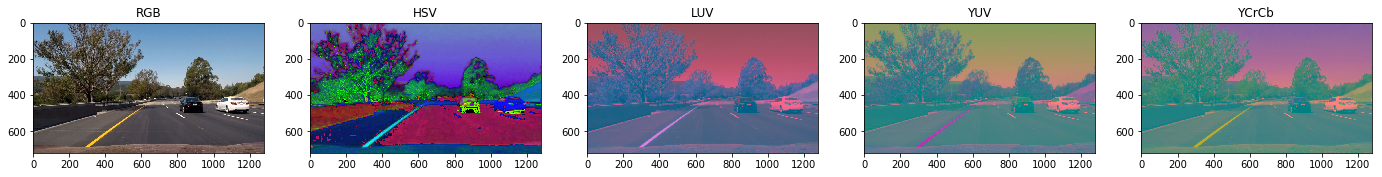

In [9]:
images = [
    './test_images/test1.jpg',
    './test_images/test2.jpg',
    './test_images/test3.jpg',
    './test_images/test4.jpg',
    './test_images/test5.jpg',
    './test_images/test6.jpg'
]

    
for img in images:
    image = mpimg.imread(img)
    
    # Note: if images are .PNG files uncomment the line below
    # car = image.astype(np.float32)/255
    
    # To visualize output for test images, uncomment
    f, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(24, 9))
    ax1.set_title('RGB')
    ax1.imshow(cvt_colorspace(image, 'RGB'))
    ax2.set_title('HSV')
    ax2.imshow(cvt_colorspace(image, 'HSV'))
    ax3.set_title('LUV')
    ax3.imshow(cvt_colorspace(image, 'LUV'))
    ax4.set_title('YUV')
    ax4.imshow(cvt_colorspace(image, 'YUV'))
    ax5.set_title('YCrCb')
    ax5.imshow(cvt_colorspace(image, 'YCrCb'))

#### Initialize Parameters

In [10]:
class Features():
    def __init__(self):
        self.color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
        self.orient = 9  # HOG orientations
        self.pix_per_cell = 8 # HOG pixels per cell
        self.cell_per_block = 2 # HOG cells per block
        self.hog_channel = 0 # Can be 0, 1, 2, or "ALL"
        self.spatial_size = (16, 16) # Spatial binning dimensions
        self.hist_bins = 16    # Number of histogram bins
        self.spatial_feat = True # Spatial features on or off
        self.hist_feat = False # Histogram features on or off
        self.hog_feat = True # HOG features on or off
        self.y_start_stop = [400, 656] # Min and max in y to search in slide_window()
        self.heat_thresh = 3 # heat threshold
        self.scale = 1.5
        self.window_size = (96, 96)
        
        
features = Features()

#### Extract Features From Data

In [11]:
# for testing, use sample of training data
# sample_size = 500
# cars = cars[0:sample_size]
# notcars = notcars[0:sample_size]

# extract car features
car_features = extract_features(cars,
                                color_space=features.color_space,
                                spatial_size=features.spatial_size,
                                hist_bins=features.hist_bins,
                                orient=features.orient,
                                pix_per_cell=features.pix_per_cell,
                                cell_per_block=features.cell_per_block,
                                hog_channel=features.hog_channel,
                                spatial_feat=features.spatial_feat,
                                hist_feat=features.hist_feat,
                                hog_feat=features.hog_feat)
# extract not car features
notcar_features = extract_features(notcars,
                                   color_space=features.color_space,
                                   spatial_size=features.spatial_size,
                                   hist_bins=features.hist_bins,
                                   orient=features.orient,
                                   pix_per_cell=features.pix_per_cell,
                                   cell_per_block=features.cell_per_block,
                                   hog_channel=features.hog_channel,
                                   spatial_feat=features.spatial_feat,
                                   hist_feat=features.hist_feat,
                                   hog_feat=features.hog_feat)

In [12]:
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Shuffle data and slit data into a training and test set a
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

# Fit a per-column scaler
X_scaler = StandardScaler().fit(X_train)

# Apply the scaler to X
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

print('Feature vector length:', len(X_train[0]))

Feature vector length: 2532


### Parameter Tuning

In [13]:
svc = svm.SVC()
parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
svc = GridSearchCV(svc, parameters)
svc.fit(X_train, y_train)

print('Score: ', round(svc.score(X_test, y_test), 4))
print('Best Params: ', svc.best_params_)

Score:  0.955
Best Params:  {'kernel': 'rbf', 'C': 10}


#### Best model based on parameter tuning

In [13]:
svc = svm.SVC(kernel='rbf', C=10)
svc.fit(X_train, y_train)
print('Score: ', round(svc.score(X_test, y_test), 4))

Score:  0.9885


In [32]:
def pipeline(image):
    
    color_space= features.color_space
    orient = features.orient
    pix_per_cell = features.pix_per_cell
    cell_per_block = features.cell_per_block
    hog_channel = features.hog_channel
    spatial_size = features.spatial_size
    hist_bins = features.hist_bins
    spatial_feat = features.spatial_feat
    hist_feat = features.hist_feat
    hog_feat = features.hog_feat
    y_start_stop = features.y_start_stop
    heat_thresh = features.heat_thresh
    scale = features.scale
    window_size = features.window_size
    
    draw_image = np.copy(image)
    
    # to display test images, uncomment next two lines
    # windows_img = np.copy(image)
    # hot_img = np.copy(image)
    
    image = image.astype(np.float32)/255
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    
    # get list of searchable windowns
    windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                        xy_window=(98, 98), xy_overlap=(0.75, 0.75))
    
    # get hot windows
    hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)                       

    # to display test images, uncomment next two lines
    # window_img = draw_boxes(windows_img, windows, color=(0, 0, 255), thick=6)
    # hot = draw_boxes(hot_img, hot_windows, color=(0, 0, 255), thick=6)

    # Add heat to each box in box list
    heat = add_heat(heat, hot_windows)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat, 2)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    car_position = draw_labeled_bboxes(draw_image, labels)
    
    # To visualize output for test images, uncomment
#     f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(24, 9))
#     ax1.set_title('Windows')
#     ax1.imshow(window_img)
#     ax2.set_title('Hot Windows')
#     ax2.imshow(hot)
#     ax3.set_title('Car Position')
#     ax3.imshow(car_position)
#     ax4.set_title('Heat Map')
#     ax4.imshow(heatmap, cmap='hot')
    
    return car_position

#### Test Images

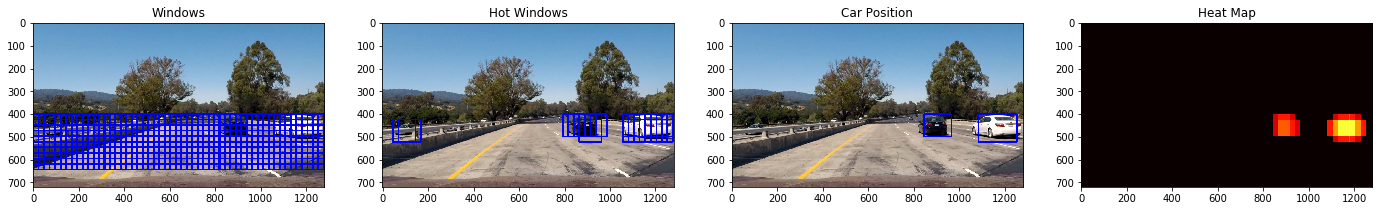

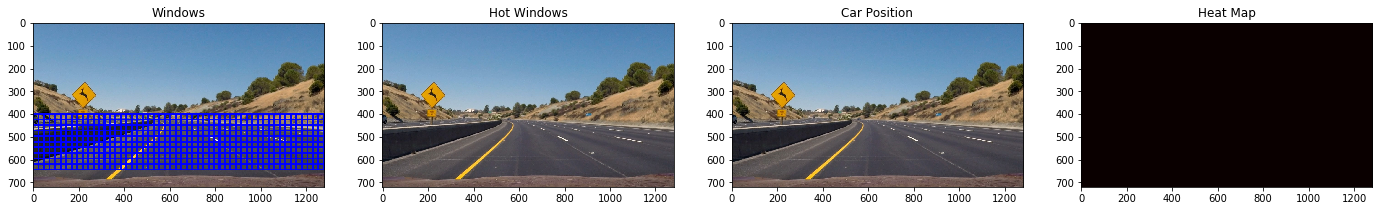

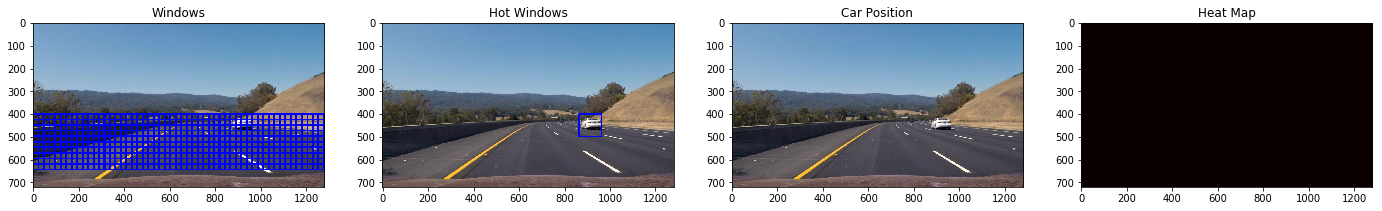

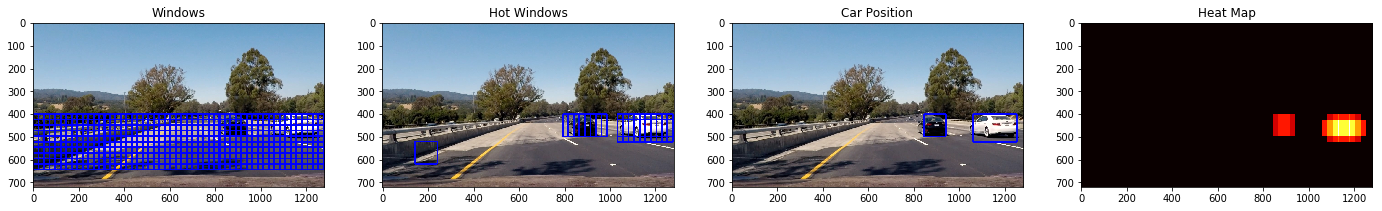

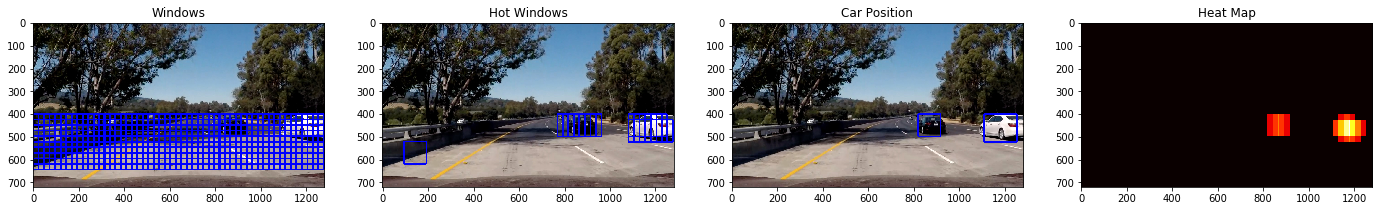

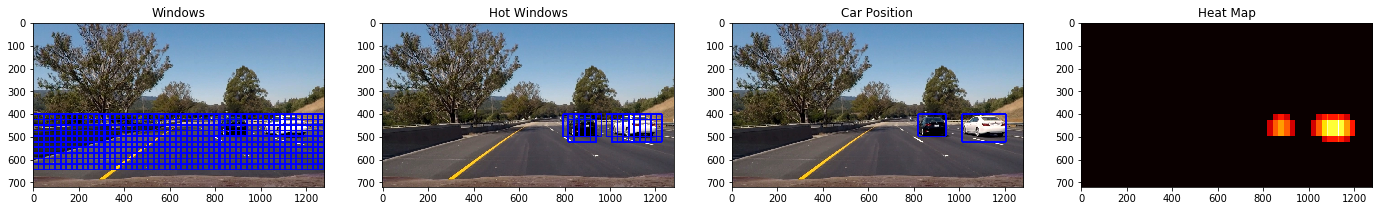

In [27]:
images = [
    './test_images/test1.jpg',
    './test_images/test2.jpg',
    './test_images/test3.jpg',
    './test_images/test4.jpg',
    './test_images/test5.jpg',
    './test_images/test6.jpg'
]

for direc in images:

    image = mpimg.imread(direc)

    pip = pipeline(image)

In [29]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
# from moviepy.editor import *
from IPython.display import HTML

In [30]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # you should return the final output (image where lines are drawn on lanes)
    # read in colored image

    return pipeline(image)

In [33]:
white_output = 'test_videos_output/project_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
# clip1 = VideoFileClip("./project_video.mp4").subclip(0,5)
clip1 = VideoFileClip("./project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!

%time white_clip.write_videofile(white_output, audio=False)
# white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/project_video.mp4
[MoviePy] Writing video test_videos_output/project_video.mp4


100%|█████████▉| 1260/1261 [59:20<00:02,  2.83s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/project_video.mp4 

CPU times: user 1h 26min 1s, sys: 20.2 s, total: 1h 26min 21s
Wall time: 59min 21s
